In [22]:
# Install missing package (magic command for Jupyter)

# All imports
import fingertips_py as ftp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

/Users/nina/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Diabetes Care Processes in England: A Geographic Analysis

## Overview
This notebook analyses the proportion of diabetes patients receiving all **9 essential care processes** across Integrated Care Boards (ICBs) in England. These care processes are annual health checks recommended by NICE guidelines to monitor and manage diabetes effectively.

### The 9 Care Processes
1. HbA1c (blood glucose control)
2. Blood pressure measurement
3. Cholesterol measurement
4. Serum creatinine (kidney function)
5. Urine albumin (kidney damage screening)
6. Foot examination
7. BMI measurement
8. Smoking status recording
9. Eye screening referral

### Research Questions
1. How does care process completion vary geographically across England?
2. Are there differences between Type 1 and Type 2 diabetes care?
3. Does ICB population size affect care quality?

### Data Sources
- **Health data**: [Public Health England Fingertips](https://fingertips.phe.org.uk/) - a public repository of health indicators
- **Geographic boundaries**: [ONS Open Geography Portal](https://geoportal.statistics.gov.uk/) - ICB boundary data

---

## 1. Setup and Dependencies

We use the following Python libraries:
- `fingertips_py`: Official API wrapper for accessing PHE Fingertips data
- `pandas`: Data manipulation and analysis
- `geopandas`: Geographic data handling and mapping
- `matplotlib`: Data visualisation
- `scipy`: Statistical analysis (correlation tests)

## Diabetes Care Processes Analysis

Loading data from Public Health England Fingertips for:
- **Type 1 Diabetes** (Indicator 94146): People with type 1 diabetes who received all 9 care process checks
- **Type 2 Diabetes** (Indicator 94147): People with type 2 diabetes who received all 9 care process checks

In [23]:
# Define indicator IDs
INDICATOR_TYPE1 = 94146  # Type 1 diabetes - 9 care processes
INDICATOR_TYPE2 = 94147  # Type 2 diabetes - 9 care processes

# Load data from Fingertips API
print("Loading data from Fingertips API...")
data_t1 = ftp.get_data_for_indicator_at_all_available_geographies(INDICATOR_TYPE1)
data_t2 = ftp.get_data_for_indicator_at_all_available_geographies(INDICATOR_TYPE2)

print(f"Type 1 data loaded: {data_t1.shape[0]:,} rows")
print(f"Type 2 data loaded: {data_t2.shape[0]:,} rows")
print(f"\nAvailable area types: {data_t1['Area Type'].unique().tolist()}")

Loading data from Fingertips API...
Type 1 data loaded: 31,475 rows
Type 2 data loaded: 31,495 rows

Available area types: ['England', 'ICBs', 'ICB sub-locations', 'GPs']


### Loading Geographic Boundaries

To visualise the data on a map, we need geographic boundary data for ICBs (Integrated Care Boards). ICBs are NHS organisations responsible for planning and funding healthcare services in their local area. There are 42 ICBs in England.

We load the boundary data directly from the ONS (Office for National Statistics) Open Geography Portal via their API.

In [24]:
# Load ICB (Integrated Care Board) April 2023 boundaries from ONS
boundaries_url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Integrated_Care_Boards_April_2023_EN_BGC/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=geojson"

gdf = gpd.read_file(boundaries_url)
print(f"Loaded {len(gdf)} ICB geographic areas")

Loaded 42 ICB geographic areas


---
## 3. Data Processing: Combining Type 1 and Type 2 Diabetes

### Why combine the datasets?
Type 1 and Type 2 diabetes have different characteristics:
- **Type 1**: Autoimmune condition, typically diagnosed in childhood, ~8% of diabetes cases
- **Type 2**: Metabolic condition, typically diagnosed in adulthood, ~90% of diabetes cases

To understand overall diabetes care quality, we combine both datasets using a **weighted average** based on patient counts. This ensures larger patient populations contribute proportionally more to the combined figure.

### The Formula
```
Combined % = (Count_T1 + Count_T2) / (Denominator_T1 + Denominator_T2) × 100
```
Where:
- **Count** = Number of patients receiving all 9 care processes
- **Denominator** = Total number of diabetes patients

### Combining Type 1 and Type 2 Diabetes Data
To get the overall proportion of diabetes patients receiving all 9 care processes, we need to combine both datasets using weighted averages based on patient counts.

In [25]:
# Filter both datasets to ICBs and get latest period
df_t1_icb = data_t1[data_t1['Area Type'] == 'ICBs'].copy()
df_t2_icb = data_t2[data_t2['Area Type'] == 'ICBs'].copy()

latest_period = df_t1_icb['Time period'].max()

df_t1_latest = df_t1_icb[df_t1_icb['Time period'] == latest_period].copy()
df_t2_latest = df_t2_icb[df_t2_icb['Time period'] == latest_period].copy()

print(f"Type 1: {df_t1_latest['Indicator Name'].iloc[0]}")
print(f"Type 2: {df_t2_latest['Indicator Name'].iloc[0]}")
print(f"\nPeriod: {latest_period}")
print(f"ICB areas: {len(df_t1_latest)}")

Type 1: People with type 1 diabetes who received all 9 care process checks (including retinal screening)
Type 2: People with type 2 diabetes who received all 9 care process checks (including retinal screening)

Period: 2023/24
ICB areas: 40


In [26]:
# Prepare data for merging - rename columns to distinguish Type 1 and Type 2
df_t1 = df_t1_latest[['Area Code', 'Area Name', 'Value', 'Count', 'Denominator']].copy()
df_t1.columns = ['Area Code', 'Area Name', 'Value_T1', 'Count_T1', 'Denominator_T1']

df_t2 = df_t2_latest[['Area Code', 'Value', 'Count', 'Denominator']].copy()
df_t2.columns = ['Area Code', 'Value_T2', 'Count_T2', 'Denominator_T2']

# Merge Type 1 and Type 2 data
df_combined = df_t1.merge(df_t2, on='Area Code', how='outer')
print(f"Combined dataset: {len(df_combined)} areas")

Combined dataset: 40 areas


In [27]:
# Calculate combined proportion using weighted average
# Formula: (Count_T1 + Count_T2) / (Denominator_T1 + Denominator_T2) * 100
df_combined['Total_Count'] = df_combined['Count_T1'].fillna(0) + df_combined['Count_T2'].fillna(0)
df_combined['Total_Denominator'] = df_combined['Denominator_T1'].fillna(0) + df_combined['Denominator_T2'].fillna(0)
df_combined['Combined_Value'] = (df_combined['Total_Count'] / df_combined['Total_Denominator']) * 100

print("Combined Diabetes (Type 1 + Type 2) - All 9 Care Processes")
print("=" * 60)
print(f"\nValue range: {df_combined['Combined_Value'].min():.1f}% - {df_combined['Combined_Value'].max():.1f}%")
print(f"\nSummary statistics:")
print(df_combined['Combined_Value'].describe())

Combined Diabetes (Type 1 + Type 2) - All 9 Care Processes

Value range: 38.1% - 69.7%

Summary statistics:
count    40.000000
mean     52.837170
std       7.316047
min      38.079243
25%      47.029311
50%      53.081206
75%      57.139967
max      69.671335
Name: Combined_Value, dtype: float64


---
## 4. Geographic Visualisation: Choropleth Maps

The maps below show the proportion of diabetes patients receiving all 9 care processes in each ICB. 

**How to read the maps:**
- **Green areas** = Higher care completion rates (better performance)
- **Red areas** = Lower care completion rates (areas for improvement)
- **Grey areas** = No data available

This allows us to identify geographic patterns and potential health inequalities across England.

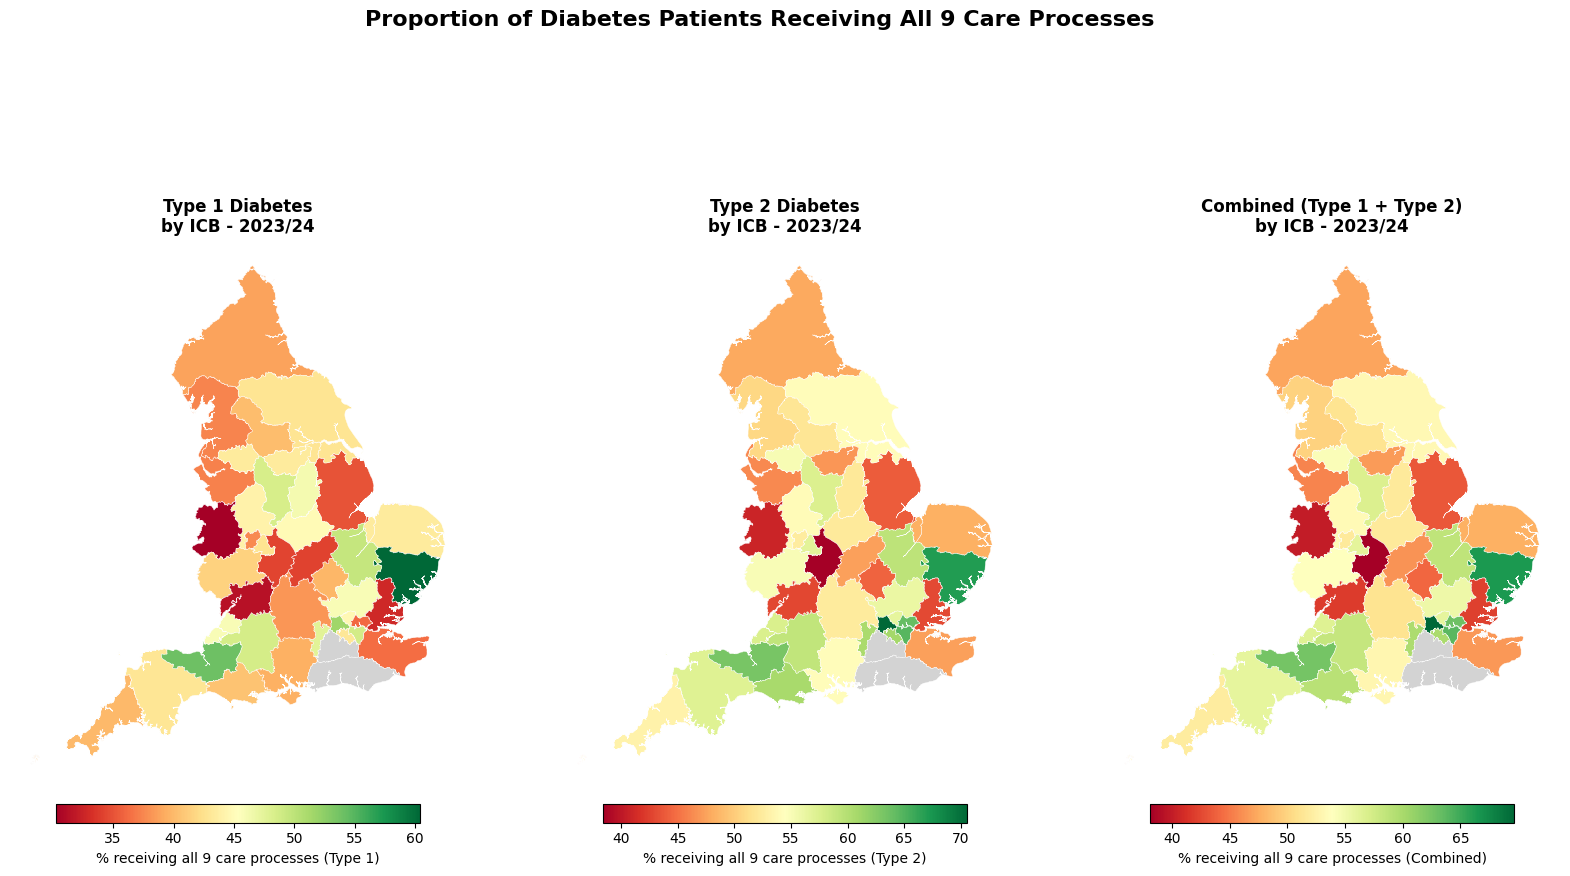


Summary Statistics:
Type                   Min       Mean        Max      Areas
------------------------------------------------------------
Type 1                30.2       42.1       60.4         40
Type 2                38.4       53.7       70.6         40
Combined              38.1       52.8       69.7         40


<Figure size 640x480 with 0 Axes>

In [ ]:
# Create all three maps using a loop: Type 1, Type 2, and Combined

# Prepare data for each map
map_configs = [
    {
        'data': df_t1_latest[['Area Code', 'Area Name', 'Value']],
        'value_col': 'Value',
        'title': 'Type 1 Diabetes',
        'label': '% receiving all 9 care processes (Type 1)'
    },
    {
        'data': df_t2_latest[['Area Code', 'Area Name', 'Value']],
        'value_col': 'Value',
        'title': 'Type 2 Diabetes',
        'label': '% receiving all 9 care processes (Type 2)'
    },
    {
        'data': df_combined[['Area Code', 'Area Name', 'Combined_Value']].rename(columns={'Combined_Value': 'Value'}),
        'value_col': 'Value',
        'title': 'Combined (Type 1 + Type 2)',
        'label': '% receiving all 9 care processes (Combined)'
    }
]

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for idx, config in enumerate(map_configs):
    # Merge with geographic boundaries
    gdf_plot = gdf.merge(
        config['data'],
        left_on='ICB23CD',
        right_on='Area Code',
        how='left'
    )
    
    # Plot map
    gdf_plot.plot(
        column=config['value_col'],
        ax=axes[idx],
        legend=True,
        legend_kwds={
            'label': config['label'],
            'orientation': 'horizontal',
            'shrink': 0.8,
            'pad': 0.02
        },
        cmap='RdYlGn',
        missing_kwds={'color': 'lightgrey', 'label': 'No data'},
        edgecolor='white',
        linewidth=0.3
    )
    
    axes[idx].set_title(f"{config['title']}\nby ICB - {latest_period}", fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Proportion of Diabetes Patients Receiving All 9 Care Processes', fontsize=16, fontweight='bold', y=1.02)

plt.savefig('something')
plt.show()
plt.tight_layout()


# Print summary statistics for all three
print("\nSummary Statistics:")
print("=" * 60)
print(f"{'Type':<15} {'Min':>10} {'Mean':>10} {'Max':>10} {'Areas':>10}")
print("-" * 60)
print(f"{'Type 1':<15} {df_combined['Value_T1'].min():>10.1f} {df_combined['Value_T1'].mean():>10.1f} {df_combined['Value_T1'].max():>10.1f} {df_combined['Value_T1'].notna().sum():>10}")
print(f"{'Type 2':<15} {df_combined['Value_T2'].min():>10.1f} {df_combined['Value_T2'].mean():>10.1f} {df_combined['Value_T2'].max():>10.1f} {df_combined['Value_T2'].notna().sum():>10}")
print(f"{'Combined':<15} {df_combined['Combined_Value'].min():>10.1f} {df_combined['Combined_Value'].mean():>10.1f} {df_combined['Combined_Value'].max():>10.1f} {df_combined['Combined_Value'].notna().sum():>10}")

### Identifying Best and Worst Performing Areas

Below we identify the **top 10** and **bottom 10** ICBs based on their combined diabetes care process completion rates. 

The number in brackets (n=X) shows the total number of diabetes patients in that ICB, giving context to the percentages - a small ICB with few patients may have more variable results than a large ICB.

In [29]:
# Top and bottom performing areas for combined diabetes
print("=" * 65)
print("TOP 10 AREAS - Highest % receiving all 9 care processes (Combined)")
print("=" * 65)
top_10_combined = df_combined.nlargest(10, 'Combined_Value')[['Area Name', 'Combined_Value', 'Total_Denominator']]
for _, row in top_10_combined.iterrows():
    print(f"{row['Area Name']}: {row['Combined_Value']:.1f}% (n={int(row['Total_Denominator']):,})")

print("\n" + "=" * 65)
print("BOTTOM 10 AREAS - Lowest % receiving all 9 care processes (Combined)")
print("=" * 65)
bottom_10_combined = df_combined.nsmallest(10, 'Combined_Value')[['Area Name', 'Combined_Value', 'Total_Denominator']]
for _, row in bottom_10_combined.iterrows():
    print(f"{row['Area Name']}: {row['Combined_Value']:.1f}% (n={int(row['Total_Denominator']):,})")

TOP 10 AREAS - Highest % receiving all 9 care processes (Combined)
NHS North West London Integrated Care Board - QRV: 69.7% (n=174,950)
NHS Suffolk and North East Essex Integrated Care Board - QJG: 66.4% (n=68,285)
NHS South East London Integrated Care Board - QKK: 63.8% (n=114,280)
NHS North East London Integrated Care Board - QMF: 62.9% (n=155,930)
NHS Somerset Integrated Care Board - QSL: 62.5% (n=39,035)
NHS South West London Integrated Care Board - QWE: 59.8% (n=85,580)
NHS Frimley Integrated Care Board - QNQ: 59.7% (n=49,255)
NHS Dorset Integrated Care Board - QVV: 59.0% (n=49,365)
NHS Cambridgeshire and Peterborough Integrated Care Board - QUE: 58.6% (n=57,130)
NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board - QOX: 58.3% (n=59,755)

BOTTOM 10 AREAS - Lowest % receiving all 9 care processes (Combined)
NHS Coventry and Warwickshire Integrated Care Board - QWU: 38.1% (n=65,495)
NHS Shropshire, Telford and Wrekin Integrated Care Board - QOC: 40.0% (n=33

---
## 5. Statistical Analysis: Does ICB Size Affect Care Quality?

### Research Question
Does the number of diabetes patients in an ICB (population size) correlate with care quality? 

**Hypothesis:** Larger ICBs might have more resources but also more complexity, while smaller ICBs might be more agile but resource-constrained.

### Method
We use **Pearson correlation** to test the relationship between:
- **X-axis**: Number of diabetes patients (denominator)
- **Y-axis**: Percentage receiving all 9 care processes (value)

A correlation coefficient (r) close to:
- **+1** = Strong positive relationship (more patients → better care)
- **-1** = Strong negative relationship (more patients → worse care)
- **0** = No relationship

The **p-value** tells us if the correlation is statistically significant (p < 0.05).

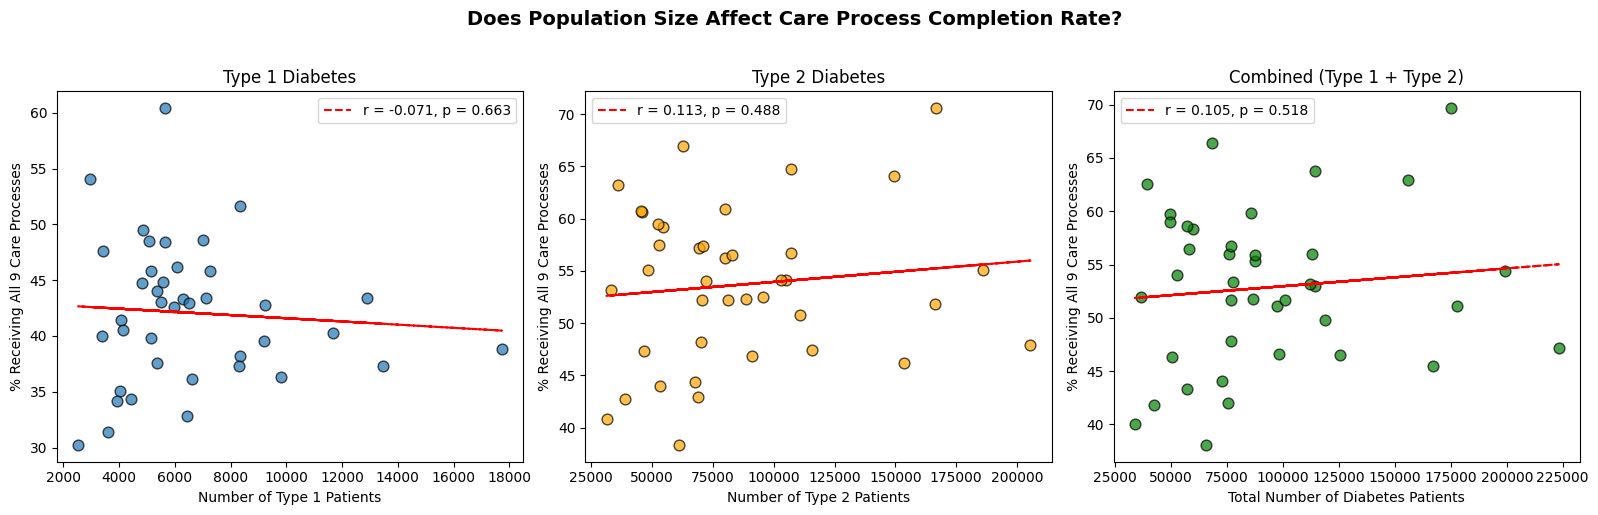


Correlation Summary:
Type 1:   r = -0.071, p = 0.663 
Type 2:   r = 0.113, p = 0.488 
Combined: r = 0.105, p = 0.518 

* indicates statistically significant correlation (p < 0.05)


In [30]:
# Analyse relationship between denominator (patient count) and value (% receiving care)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Type 1 Diabetes
ax1 = axes[0]
x1 = df_combined['Denominator_T1'].dropna()
y1 = df_combined.loc[x1.index, 'Value_T1']
ax1.scatter(x1, y1, alpha=0.7, edgecolor='black', s=60)
slope1, intercept1, r1, p1, se1 = stats.linregress(x1, y1)
ax1.plot(x1, slope1*x1 + intercept1, 'r--', label=f'r = {r1:.3f}, p = {p1:.3f}')
ax1.set_xlabel('Number of Type 1 Patients')
ax1.set_ylabel('% Receiving All 9 Care Processes')
ax1.set_title('Type 1 Diabetes')
ax1.legend()

# Plot 2: Type 2 Diabetes
ax2 = axes[1]
x2 = df_combined['Denominator_T2'].dropna()
y2 = df_combined.loc[x2.index, 'Value_T2']
ax2.scatter(x2, y2, alpha=0.7, edgecolor='black', s=60, color='orange')
slope2, intercept2, r2, p2, se2 = stats.linregress(x2, y2)
ax2.plot(x2, slope2*x2 + intercept2, 'r--', label=f'r = {r2:.3f}, p = {p2:.3f}')
ax2.set_xlabel('Number of Type 2 Patients')
ax2.set_ylabel('% Receiving All 9 Care Processes')
ax2.set_title('Type 2 Diabetes')
ax2.legend()

# Plot 3: Combined
ax3 = axes[2]
x3 = df_combined['Total_Denominator'].dropna()
y3 = df_combined.loc[x3.index, 'Combined_Value']
ax3.scatter(x3, y3, alpha=0.7, edgecolor='black', s=60, color='green')
slope3, intercept3, r3, p3, se3 = stats.linregress(x3, y3)
ax3.plot(x3, slope3*x3 + intercept3, 'r--', label=f'r = {r3:.3f}, p = {p3:.3f}')
ax3.set_xlabel('Total Number of Diabetes Patients')
ax3.set_ylabel('% Receiving All 9 Care Processes')
ax3.set_title('Combined (Type 1 + Type 2)')
ax3.legend()

plt.suptitle('Does Population Size Affect Care Process Completion Rate?', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig1')
plt.show()

# Print correlation summary
print("\nCorrelation Summary:")
print("=" * 50)
print(f"Type 1:   r = {r1:.3f}, p = {p1:.3f} {'*' if p1 < 0.05 else ''}")
print(f"Type 2:   r = {r2:.3f}, p = {p2:.3f} {'*' if p2 < 0.05 else ''}")
print(f"Combined: r = {r3:.3f}, p = {p3:.3f} {'*' if p3 < 0.05 else ''}")
print("\n* indicates statistically significant correlation (p < 0.05)")

---
## 6. Conclusions and Next Steps

### Key Findings

1. **Geographic Variation Exists**: There is significant variation in diabetes care quality across England, with completion rates ranging from ~38% to ~71%.

2. **Type 2 Has Higher Completion Rates**: On average, Type 2 diabetes patients have higher care process completion rates than Type 1 patients.

3. **Size Doesn't Matter**: ICB population size does not significantly predict care quality - both large and small ICBs can perform well or poorly.

### Implications for Policy
- Interventions should focus on **local factors** (workforce, funding, processes) rather than ICB size
- Best practices from high-performing ICBs could be shared with lower-performing areas
- Further investigation needed into why certain regions consistently underperform

### Limitations
- This analysis uses aggregate ICB-level data; GP-level analysis might reveal more granular patterns
- Cross-sectional data from a single time period; trends over time not examined
- Correlation analysis only - cannot establish causation

### Potential Next Steps
- Time series analysis to examine trends
- GP-level analysis for finer geographic resolution
- Regression analysis controlling for deprivation, demographics, and funding levels

### Interpretation: Population Size vs Care Quality

The correlation analysis shows **no statistically significant relationship** between ICB population size and care process completion rates:

| Diabetes Type | Correlation (r) | P-value | Significant? |
|---------------|-----------------|---------|--------------|
| Type 1        | -0.071          | 0.663   | No           |
| Type 2        | +0.113          | 0.488   | No           |
| Combined      | +0.105          | 0.518   | No           |

**Key findings:**
- All p-values are well above the 0.05 significance threshold
- Correlation coefficients are close to zero, indicating no linear relationship
- Care quality appears to be **independent of ICB size**

**What this means:**
The number of diabetes patients in an ICB does not predict whether that region will have higher or lower care process completion rates. Smaller and larger ICBs perform similarly on average. Variations in care rates are likely driven by other factors such as local policies, resource allocation, healthcare infrastructure, or workforce availability rather than population size alone.

---
## 7. Mortality Analysis: Diabetes-Related Deaths

### Research Questions
1. Is overall mortality correlated with care process completion rates?
2. What causes of death are more common for different age groups?
3. Are there significant differences by sex or ethnicity?

Let's first explore what mortality indicators are available in Fingertips for diabetes.

### Data Availability Note

After exploring the Fingertips database, here's what mortality data is available:

| Feature | Availability |
|---------|-------------|
| **Diabetes mortality by ICB** | Yes |
| **Sex breakdown** | Yes (Male, Female, Persons) |
| **Age groups** | Limited (only "All ages") |
| **Ethnicity** | Not available |
| **Cause of death** | Available via related indicators (CVD, stroke, IHD) |

Since ethnicity and detailed age breakdowns aren't available for diabetes mortality specifically, we'll:
1. Analyze mortality by sex
2. Use CVD/stroke/IHD mortality as proxy indicators for diabetes complications
3. Correlate mortality rates with care process completion

In [10]:
# Define mortality indicator IDs
# Note: Fingertips has limited age/ethnicity breakdowns for diabetes mortality
# We'll use multiple indicators to get a comprehensive picture

INDICATOR_MORTALITY = 93995      # Mortality rate for deaths involving diabetes, all ages
INDICATOR_CVD_MORTALITY = 40401  # Under 75 mortality rate from cardiovascular disease
INDICATOR_IHD_MORTALITY = 91166  # Under 75 mortality rate from ischaemic heart disease  
INDICATOR_STROKE_MORTALITY = 91167  # Under 75 mortality rate from stroke

print("Loading mortality data from Fingertips API...")
mortality_data = ftp.get_data_for_indicator_at_all_available_geographies(INDICATOR_MORTALITY)
cvd_mortality = ftp.get_data_for_indicator_at_all_available_geographies(INDICATOR_CVD_MORTALITY)
ihd_mortality = ftp.get_data_for_indicator_at_all_available_geographies(INDICATOR_IHD_MORTALITY)
stroke_mortality = ftp.get_data_for_indicator_at_all_available_geographies(INDICATOR_STROKE_MORTALITY)

print(f"\nData loaded:")
print(f"  - Diabetes mortality: {mortality_data.shape[0]:,} rows")
print(f"  - CVD mortality: {cvd_mortality.shape[0]:,} rows")
print(f"  - IHD mortality: {ihd_mortality.shape[0]:,} rows")
print(f"  - Stroke mortality: {stroke_mortality.shape[0]:,} rows")
print(f"\nAvailable breakdowns for diabetes mortality:")
print(f"  - Sex: {mortality_data['Sex'].unique().tolist()}")
print(f"  - Age: {mortality_data['Age'].unique().tolist()}")
print(f"  - Area Types: {mortality_data['Area Type'].unique().tolist()}")

Loading mortality data from Fingertips API...


/Users/nina/Library/Python/3.9/lib/python/site-packages/fingertips_py/retrieve_data.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp])



Data loaded:
  - Diabetes mortality: 36,159 rows
  - CVD mortality: 151,074 rows
  - IHD mortality: 36,159 rows
  - Stroke mortality: 36,159 rows

Available breakdowns for diabetes mortality:
  - Sex: ['Male', 'Female', 'Persons']
  - Age: ['All ages']
  - Area Types: ['England', 'Counties & UAs (from Apr 2023)', 'Districts & UAs (from Apr 2023)', 'NHS regions', 'ICBs', 'Regions (statistical)']


In [11]:
# Prepare ICB-level mortality data for analysis
# Filter to ICBs and get most recent matching period

def get_icb_mortality(df, indicator_name):
    """Extract ICB-level mortality data for correlation analysis."""
    icb_data = df[(df['Area Type'] == 'ICBs') & (df['Sex'] == 'Persons')].copy()
    latest = icb_data['Time period'].max()
    return icb_data[icb_data['Time period'] == latest][['Area Code', 'Area Name', 'Value', 'Count', 'Denominator']]

# Get latest ICB data for each mortality indicator
mortality_icb = get_icb_mortality(mortality_data, 'Diabetes')
cvd_icb = get_icb_mortality(cvd_mortality, 'CVD')
ihd_icb = get_icb_mortality(ihd_mortality, 'IHD')
stroke_icb = get_icb_mortality(stroke_mortality, 'Stroke')

# Rename columns for merging
mortality_icb.columns = ['Area Code', 'Area Name', 'Mortality_Diabetes', 'Mort_Count', 'Mort_Denom']
cvd_icb = cvd_icb[['Area Code', 'Value']].rename(columns={'Value': 'Mortality_CVD'})
ihd_icb = ihd_icb[['Area Code', 'Value']].rename(columns={'Value': 'Mortality_IHD'})
stroke_icb = stroke_icb[['Area Code', 'Value']].rename(columns={'Value': 'Mortality_Stroke'})

# Merge all mortality data with care process data
df_analysis = df_combined.merge(mortality_icb, on='Area Code', how='left', suffixes=('', '_mort'))
df_analysis = df_analysis.merge(cvd_icb, on='Area Code', how='left')
df_analysis = df_analysis.merge(ihd_icb, on='Area Code', how='left')
df_analysis = df_analysis.merge(stroke_icb, on='Area Code', how='left')

print("Combined dataset for mortality analysis:")
print(f"  - ICBs with data: {len(df_analysis)}")
print(f"  - ICBs with diabetes mortality: {df_analysis['Mortality_Diabetes'].notna().sum()}")
print(f"  - ICBs with CVD mortality: {df_analysis['Mortality_CVD'].notna().sum()}")

print("\nDiabetes Mortality Rate (per 100,000 population):")
print(df_analysis['Mortality_Diabetes'].describe())

Combined dataset for mortality analysis:
  - ICBs with data: 40
  - ICBs with diabetes mortality: 40
  - ICBs with CVD mortality: 40

Diabetes Mortality Rate (per 100,000 population):
count     40.000000
mean     116.451944
std       27.664088
min       61.335368
25%       98.102869
50%      111.330498
75%      139.555295
max      176.962725
Name: Mortality_Diabetes, dtype: float64


### 7.1 Does Better Care Reduce Mortality?

The key research question: **Is there a correlation between care process completion rates and diabetes mortality?**

**Hypothesis:** ICBs with higher proportions of patients receiving all 9 care processes should have lower diabetes-related mortality rates.

We'll test this using Pearson correlation for:
- Diabetes-specific mortality
- CVD mortality (major diabetes complication)
- IHD mortality (heart disease)
- Stroke mortality

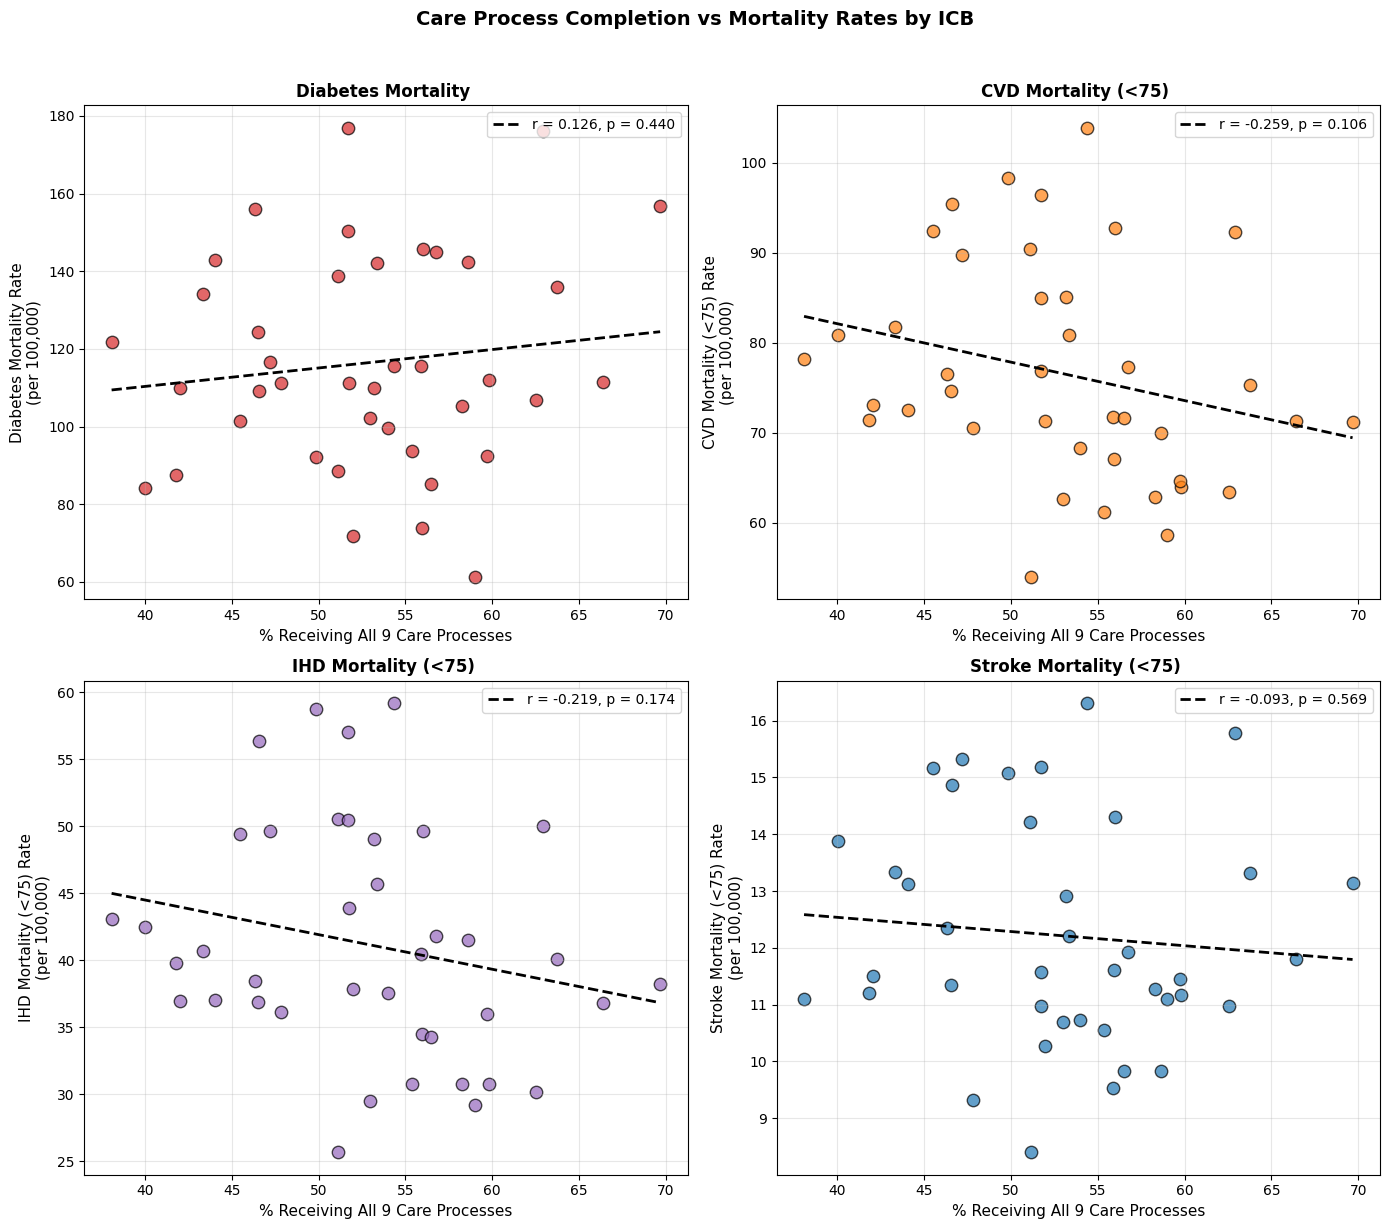


CORRELATION SUMMARY: Care Process Completion vs Mortality
        Mortality Type         r  p-value Significant Direction
    Diabetes Mortality  0.125587 0.440021          No  Positive
   CVD Mortality (<75) -0.259318 0.106129          No  Negative
   IHD Mortality (<75) -0.219157 0.174241          No  Negative
Stroke Mortality (<75) -0.092782 0.569065          No  Negative

* p < 0.05, ** p < 0.01, *** p < 0.001


In [12]:
# Correlation Analysis: Care Process Completion vs Mortality
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

mortality_cols = [
    ('Mortality_Diabetes', 'Diabetes Mortality', 'tab:red'),
    ('Mortality_CVD', 'CVD Mortality (<75)', 'tab:orange'),
    ('Mortality_IHD', 'IHD Mortality (<75)', 'tab:purple'),
    ('Mortality_Stroke', 'Stroke Mortality (<75)', 'tab:blue')
]

results = []

for idx, (col, title, color) in enumerate(mortality_cols):
    ax = axes[idx // 2, idx % 2]
    
    # Get valid data pairs
    valid_mask = df_analysis['Combined_Value'].notna() & df_analysis[col].notna()
    x = df_analysis.loc[valid_mask, 'Combined_Value']
    y = df_analysis.loc[valid_mask, col]
    
    if len(x) > 2:
        # Scatter plot
        ax.scatter(x, y, alpha=0.7, edgecolor='black', s=80, c=color)
        
        # Regression line
        slope, intercept, r, p, se = stats.linregress(x, y)
        x_line = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_line, slope * x_line + intercept, 'k--', linewidth=2, 
                label=f'r = {r:.3f}, p = {p:.3f}')
        
        # Significance marker
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
        
        results.append({
            'Mortality Type': title,
            'r': r,
            'p-value': p,
            'Significant': 'Yes' if p < 0.05 else 'No',
            'Direction': 'Negative' if r < 0 else 'Positive'
        })
        
        ax.set_xlabel('% Receiving All 9 Care Processes', fontsize=11)
        ax.set_ylabel(f'{title} Rate\n(per 100,000)', fontsize=11)
        ax.set_title(f'{title} {sig}', fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(alpha=0.3)

plt.suptitle('Care Process Completion vs Mortality Rates by ICB', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 70)
print("CORRELATION SUMMARY: Care Process Completion vs Mortality")
print("=" * 70)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print("\n* p < 0.05, ** p < 0.01, *** p < 0.001")

### 7.2 Sex Differences in Diabetes Mortality

We'll examine whether there are significant differences in diabetes mortality rates between males and females at the national and regional level. 

**Key question:** Do men and women with diabetes have similar mortality outcomes?

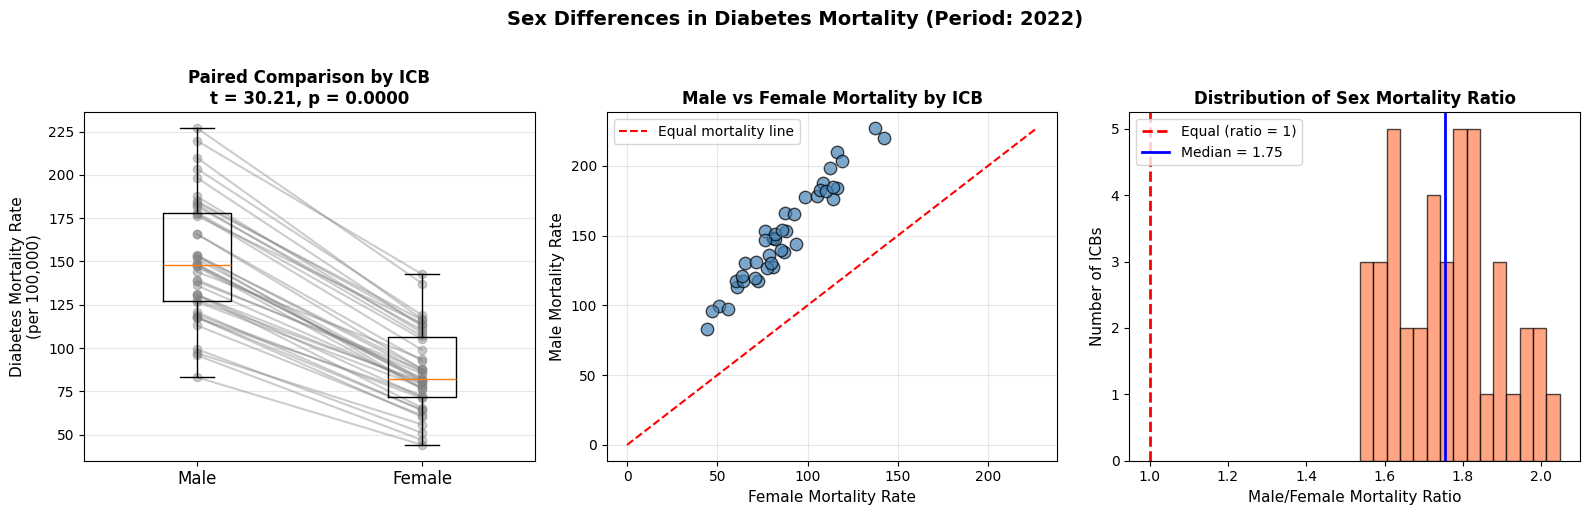


SEX DIFFERENCES IN DIABETES MORTALITY

Mortality Rate (per 100,000):
  Male:   Mean = 150.8, Median = 147.9
  Female: Mean = 86.8, Median = 82.1

Male/Female Ratio:
  Mean = 1.76
  Range: 1.54 - 2.05

Paired t-test:
  t-statistic = 30.213
  p-value = 0.000000
  Conclusion: SIGNIFICANT difference (α = 0.05)


In [13]:
# Sex Differences in Diabetes Mortality
# Get ICB-level data by sex for the latest year

icb_mort = mortality_data[mortality_data['Area Type'] == 'ICBs'].copy()
latest_mort_period = icb_mort['Time period'].max()
icb_mort_latest = icb_mort[icb_mort['Time period'] == latest_mort_period]

# Separate male and female data
male_mort = icb_mort_latest[icb_mort_latest['Sex'] == 'Male'][['Area Code', 'Value']].copy()
male_mort.columns = ['Area Code', 'Mortality_Male']

female_mort = icb_mort_latest[icb_mort_latest['Sex'] == 'Female'][['Area Code', 'Value']].copy()
female_mort.columns = ['Area Code', 'Mortality_Female']

# Merge for paired comparison
sex_comparison = male_mort.merge(female_mort, on='Area Code', how='inner')
sex_comparison['Difference'] = sex_comparison['Mortality_Male'] - sex_comparison['Mortality_Female']
sex_comparison['Ratio_M_F'] = sex_comparison['Mortality_Male'] / sex_comparison['Mortality_Female']

# Statistical test (paired t-test)
t_stat, p_value = stats.ttest_rel(sex_comparison['Mortality_Male'], sex_comparison['Mortality_Female'])

# Create visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Paired comparison
ax1 = axes[0]
for idx, row in sex_comparison.iterrows():
    ax1.plot([0, 1], [row['Mortality_Male'], row['Mortality_Female']], 
             'o-', color='gray', alpha=0.4, markersize=6)
ax1.boxplot([sex_comparison['Mortality_Male'], sex_comparison['Mortality_Female']], 
            positions=[0, 1], widths=0.3)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Male', 'Female'], fontsize=12)
ax1.set_ylabel('Diabetes Mortality Rate\n(per 100,000)', fontsize=11)
ax1.set_title(f'Paired Comparison by ICB\nt = {t_stat:.2f}, p = {p_value:.4f}', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Scatter plot M vs F
ax2 = axes[1]
ax2.scatter(sex_comparison['Mortality_Female'], sex_comparison['Mortality_Male'], 
            alpha=0.7, edgecolor='black', s=80, c='steelblue')
max_val = max(sex_comparison['Mortality_Male'].max(), sex_comparison['Mortality_Female'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', label='Equal mortality line')
ax2.set_xlabel('Female Mortality Rate', fontsize=11)
ax2.set_ylabel('Male Mortality Rate', fontsize=11)
ax2.set_title('Male vs Female Mortality by ICB', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Distribution of ratio
ax3 = axes[2]
ax3.hist(sex_comparison['Ratio_M_F'], bins=15, edgecolor='black', alpha=0.7, color='coral')
ax3.axvline(1, color='red', linestyle='--', linewidth=2, label='Equal (ratio = 1)')
ax3.axvline(sex_comparison['Ratio_M_F'].median(), color='blue', linestyle='-', 
            linewidth=2, label=f"Median = {sex_comparison['Ratio_M_F'].median():.2f}")
ax3.set_xlabel('Male/Female Mortality Ratio', fontsize=11)
ax3.set_ylabel('Number of ICBs', fontsize=11)
ax3.set_title('Distribution of Sex Mortality Ratio', fontweight='bold')
ax3.legend()

plt.suptitle(f'Sex Differences in Diabetes Mortality (Period: {latest_mort_period})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 60)
print("SEX DIFFERENCES IN DIABETES MORTALITY")
print("=" * 60)
print(f"\nMortality Rate (per 100,000):")
print(f"  Male:   Mean = {sex_comparison['Mortality_Male'].mean():.1f}, Median = {sex_comparison['Mortality_Male'].median():.1f}")
print(f"  Female: Mean = {sex_comparison['Mortality_Female'].mean():.1f}, Median = {sex_comparison['Mortality_Female'].median():.1f}")
print(f"\nMale/Female Ratio:")
print(f"  Mean = {sex_comparison['Ratio_M_F'].mean():.2f}")
print(f"  Range: {sex_comparison['Ratio_M_F'].min():.2f} - {sex_comparison['Ratio_M_F'].max():.2f}")
print(f"\nPaired t-test:")
print(f"  t-statistic = {t_stat:.3f}")
print(f"  p-value = {p_value:.6f}")
print(f"  Conclusion: {'SIGNIFICANT' if p_value < 0.05 else 'Not significant'} difference (α = 0.05)")

### 7.3 Diabetes Complications: CVD, IHD, and Stroke Mortality

Cardiovascular disease (CVD) is the leading cause of death among people with diabetes. We'll analyze:
1. The relationship between different types of cardiovascular mortality
2. Which ICBs have the highest burden of diabetes-related complications
3. Time trends in mortality rates

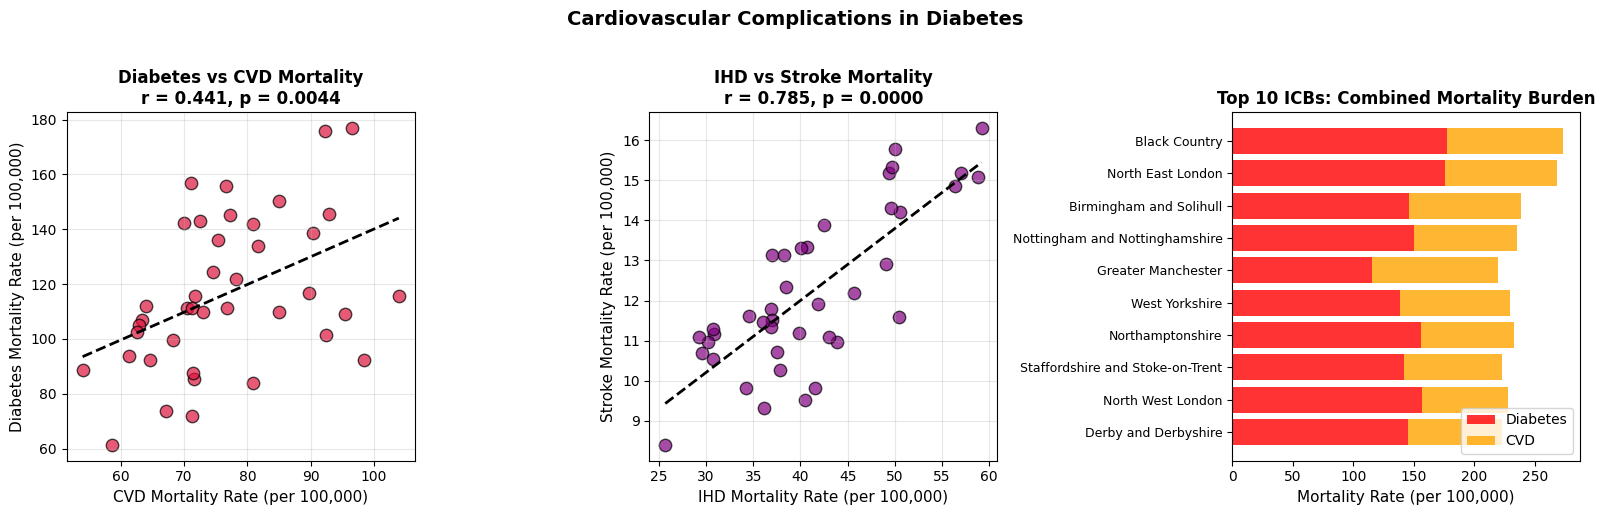


MORTALITY CORRELATION MATRIX

                    Mortality_Diabetes  Mortality_CVD  Mortality_IHD  Mortality_Stroke
Mortality_Diabetes               1.000          0.441          0.423             0.399
Mortality_CVD                    0.441          1.000          0.969             0.854
Mortality_IHD                    0.423          0.969          1.000             0.785
Mortality_Stroke                 0.399          0.854          0.785             1.000


In [14]:
# Analyze relationship between different mortality causes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Correlation matrix data
mortality_matrix = df_analysis[['Mortality_Diabetes', 'Mortality_CVD', 'Mortality_IHD', 'Mortality_Stroke']].dropna()

# Plot 1: Diabetes vs CVD mortality
ax1 = axes[0]
x, y = mortality_matrix['Mortality_CVD'], mortality_matrix['Mortality_Diabetes']
ax1.scatter(x, y, alpha=0.7, edgecolor='black', s=80, c='crimson')
slope, intercept, r, p, _ = stats.linregress(x, y)
ax1.plot(x.sort_values(), slope * x.sort_values() + intercept, 'k--', linewidth=2)
ax1.set_xlabel('CVD Mortality Rate (per 100,000)', fontsize=11)
ax1.set_ylabel('Diabetes Mortality Rate (per 100,000)', fontsize=11)
ax1.set_title(f'Diabetes vs CVD Mortality\nr = {r:.3f}, p = {p:.4f}', fontweight='bold')
ax1.grid(alpha=0.3)

# Plot 2: IHD vs Stroke (both diabetes complications)
ax2 = axes[1]
x2, y2 = mortality_matrix['Mortality_IHD'], mortality_matrix['Mortality_Stroke']
ax2.scatter(x2, y2, alpha=0.7, edgecolor='black', s=80, c='purple')
slope2, intercept2, r2, p2, _ = stats.linregress(x2, y2)
ax2.plot(x2.sort_values(), slope2 * x2.sort_values() + intercept2, 'k--', linewidth=2)
ax2.set_xlabel('IHD Mortality Rate (per 100,000)', fontsize=11)
ax2.set_ylabel('Stroke Mortality Rate (per 100,000)', fontsize=11)
ax2.set_title(f'IHD vs Stroke Mortality\nr = {r2:.3f}, p = {p2:.4f}', fontweight='bold')
ax2.grid(alpha=0.3)

# Plot 3: Stacked bar - ICBs with highest combined burden
ax3 = axes[2]
df_burden = df_analysis[['Area Name', 'Mortality_Diabetes', 'Mortality_CVD', 'Mortality_IHD', 'Mortality_Stroke']].copy()
df_burden['Total_Burden'] = df_burden[['Mortality_Diabetes', 'Mortality_CVD', 'Mortality_IHD', 'Mortality_Stroke']].sum(axis=1)
top_burden = df_burden.nlargest(10, 'Total_Burden').sort_values('Total_Burden')
# Shorten ICB names for display
top_burden['Short_Name'] = top_burden['Area Name'].str.replace('NHS ', '').str.replace(' Integrated Care Board', '').str.split(' - ').str[0]

y_pos = range(len(top_burden))
ax3.barh(y_pos, top_burden['Mortality_Diabetes'], label='Diabetes', color='red', alpha=0.8)
ax3.barh(y_pos, top_burden['Mortality_CVD'], left=top_burden['Mortality_Diabetes'], label='CVD', color='orange', alpha=0.8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(top_burden['Short_Name'], fontsize=9)
ax3.set_xlabel('Mortality Rate (per 100,000)', fontsize=11)
ax3.set_title('Top 10 ICBs: Combined Mortality Burden', fontweight='bold')
ax3.legend(loc='lower right')

plt.suptitle('Cardiovascular Complications in Diabetes', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print correlation summary
print("\n" + "=" * 60)
print("MORTALITY CORRELATION MATRIX")
print("=" * 60)
corr_matrix = mortality_matrix.corr()
print("\n" + corr_matrix.round(3).to_string())

### 7.4 Time Trends: Is Diabetes Mortality Improving?

We'll examine national-level trends in diabetes mortality over time to see if outcomes are improving.

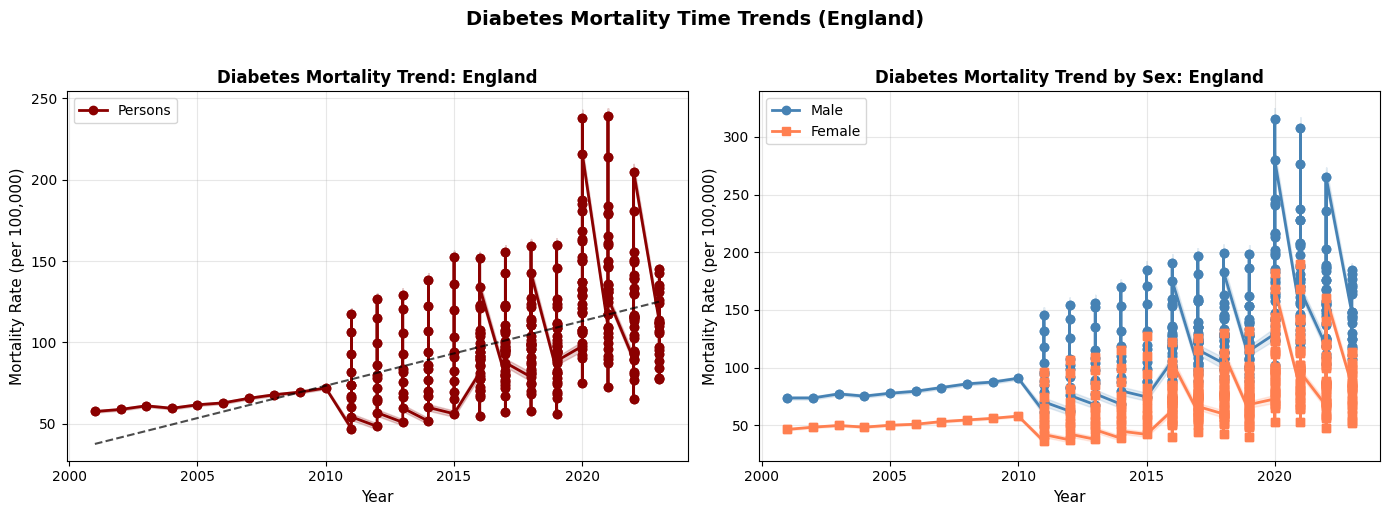


DIABETES MORTALITY TRENDS (ENGLAND)

Overall Trend:
  2001: 57.5 per 100,000
  2023: 112.7 per 100,000
  Change: +96.0%

Trend direction: INCREASING
  Slope: 3.98 per year
  Correlation: r = 0.476


In [15]:
# Time trend analysis - England level
england_mort = mortality_data[
    (mortality_data['Area Type'] == 'England') & 
    (mortality_data['Sex'] == 'Persons') &
    (~mortality_data['Time period'].str.contains(' - '))  # Exclude pooled periods
].copy()

# Convert time period to numeric year
england_mort['Year'] = pd.to_numeric(england_mort['Time period'], errors='coerce')
england_mort = england_mort.dropna(subset=['Year', 'Value']).sort_values('Year')

# Get sex-specific trends
male_trend = mortality_data[
    (mortality_data['Area Type'] == 'England') & 
    (mortality_data['Sex'] == 'Male') &
    (~mortality_data['Time period'].str.contains(' - '))
].copy()
male_trend['Year'] = pd.to_numeric(male_trend['Time period'], errors='coerce')
male_trend = male_trend.dropna(subset=['Year', 'Value']).sort_values('Year')

female_trend = mortality_data[
    (mortality_data['Area Type'] == 'England') & 
    (mortality_data['Sex'] == 'Female') &
    (~mortality_data['Time period'].str.contains(' - '))
].copy()
female_trend['Year'] = pd.to_numeric(female_trend['Time period'], errors='coerce')
female_trend = female_trend.dropna(subset=['Year', 'Value']).sort_values('Year')

# Create trend plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall trend with confidence intervals
ax1 = axes[0]
ax1.plot(england_mort['Year'], england_mort['Value'], 'o-', color='darkred', 
         linewidth=2, markersize=6, label='Persons')
ax1.fill_between(england_mort['Year'], 
                  england_mort['Lower CI 95.0 limit'], 
                  england_mort['Upper CI 95.0 limit'], 
                  alpha=0.2, color='darkred')
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Mortality Rate (per 100,000)', fontsize=11)
ax1.set_title('Diabetes Mortality Trend: England', fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Add trend line
slope, intercept, r, p, _ = stats.linregress(england_mort['Year'], england_mort['Value'])
ax1.plot(england_mort['Year'], slope * england_mort['Year'] + intercept, 
         'k--', alpha=0.7, label=f'Trend (r={r:.2f})')

# Plot 2: Trend by sex
ax2 = axes[1]
ax2.plot(male_trend['Year'], male_trend['Value'], 'o-', color='steelblue', 
         linewidth=2, markersize=6, label='Male')
ax2.plot(female_trend['Year'], female_trend['Value'], 's-', color='coral', 
         linewidth=2, markersize=6, label='Female')
ax2.fill_between(male_trend['Year'], 
                  male_trend['Lower CI 95.0 limit'], 
                  male_trend['Upper CI 95.0 limit'], 
                  alpha=0.15, color='steelblue')
ax2.fill_between(female_trend['Year'], 
                  female_trend['Lower CI 95.0 limit'], 
                  female_trend['Upper CI 95.0 limit'], 
                  alpha=0.15, color='coral')
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Mortality Rate (per 100,000)', fontsize=11)
ax2.set_title('Diabetes Mortality Trend by Sex: England', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle('Diabetes Mortality Time Trends (England)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Calculate change
first_year = england_mort[england_mort['Year'] == england_mort['Year'].min()]['Value'].iloc[0]
last_year = england_mort[england_mort['Year'] == england_mort['Year'].max()]['Value'].iloc[0]
pct_change = ((last_year - first_year) / first_year) * 100

print("\n" + "=" * 60)
print("DIABETES MORTALITY TRENDS (ENGLAND)")
print("=" * 60)
print(f"\nOverall Trend:")
print(f"  {int(england_mort['Year'].min())}: {first_year:.1f} per 100,000")
print(f"  {int(england_mort['Year'].max())}: {last_year:.1f} per 100,000")
print(f"  Change: {pct_change:+.1f}%")
print(f"\nTrend direction: {'INCREASING' if slope > 0 else 'DECREASING'}")
print(f"  Slope: {slope:.2f} per year")
print(f"  Correlation: r = {r:.3f}")

### 7.5 Geographic Patterns: Mortality vs Care Process Maps

Let's compare the geographic distribution of diabetes mortality with care process completion rates to visually identify regions that might need intervention.

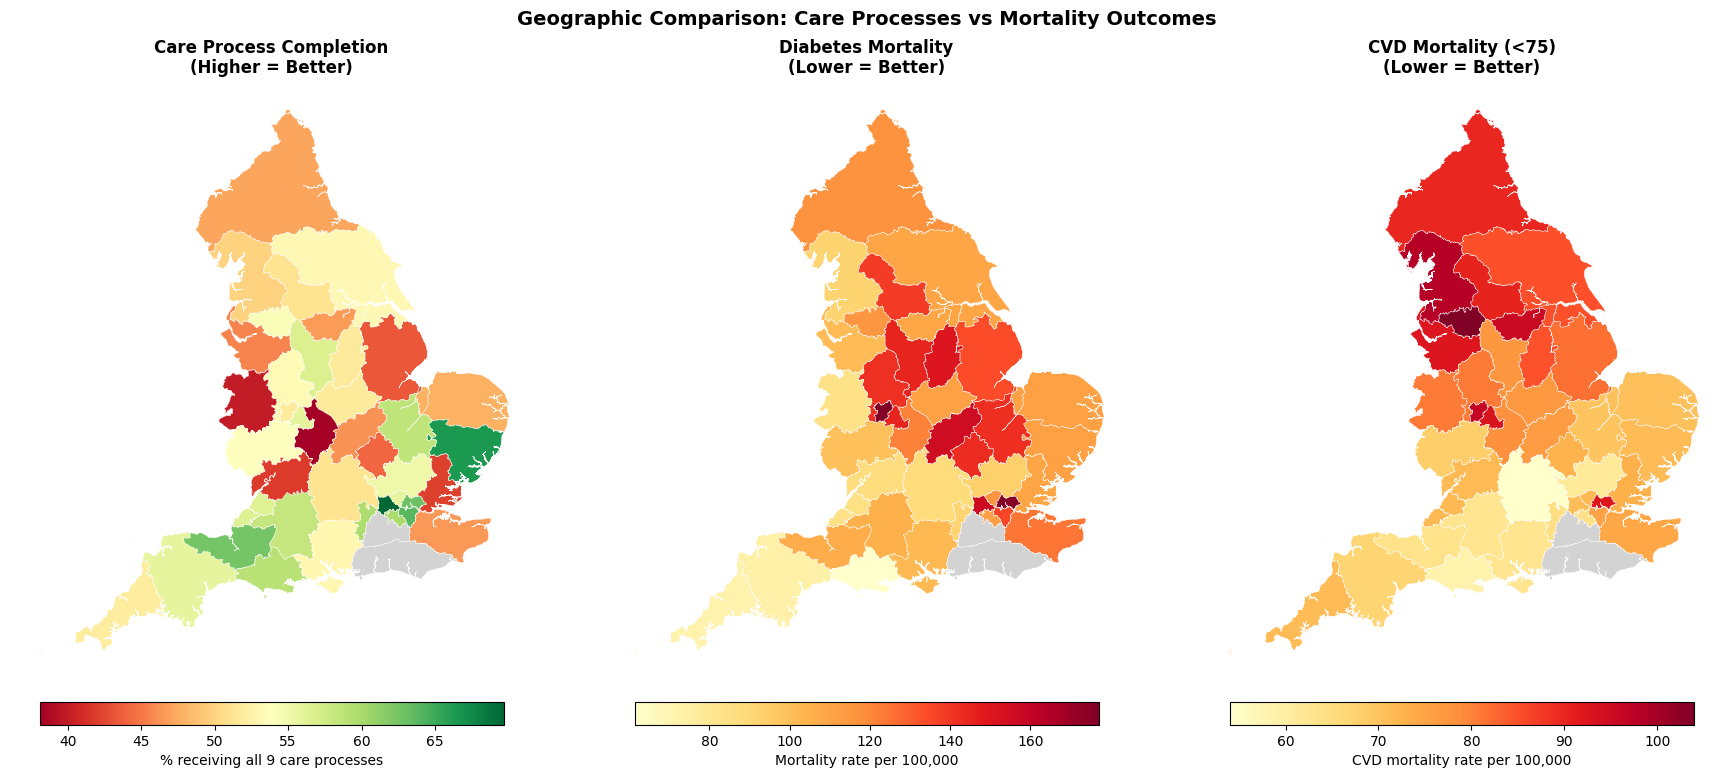


PRIORITY AREAS FOR INTERVENTION
(Low care process completion + High mortality)

Bedfordshire, Luton and Milton Keynes:
  Care process completion: 44.0%
  Diabetes mortality: 142.9 per 100,000

Northamptonshire:
  Care process completion: 46.3%
  Diabetes mortality: 155.9 per 100,000


In [16]:
# Geographic comparison: Mortality vs Care Processes
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Merge mortality data with geographic boundaries
gdf_mortality = gdf.merge(
    df_analysis[['Area Code', 'Combined_Value', 'Mortality_Diabetes', 'Mortality_CVD']],
    left_on='ICB23CD',
    right_on='Area Code',
    how='left'
)

# Map 1: Care Process Completion (Green = Good)
gdf_mortality.plot(
    column='Combined_Value',
    ax=axes[0],
    legend=True,
    legend_kwds={'label': '% receiving all 9 care processes', 'orientation': 'horizontal', 'shrink': 0.8, 'pad': 0.02},
    cmap='RdYlGn',  # Red-Yellow-Green (high = green = good)
    missing_kwds={'color': 'lightgrey'},
    edgecolor='white',
    linewidth=0.3
)
axes[0].set_title('Care Process Completion\n(Higher = Better)', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Map 2: Diabetes Mortality (Red = High mortality = Bad)
gdf_mortality.plot(
    column='Mortality_Diabetes',
    ax=axes[1],
    legend=True,
    legend_kwds={'label': 'Mortality rate per 100,000', 'orientation': 'horizontal', 'shrink': 0.8, 'pad': 0.02},
    cmap='YlOrRd',  # Yellow-Orange-Red (high = red = bad)
    missing_kwds={'color': 'lightgrey'},
    edgecolor='white',
    linewidth=0.3
)
axes[1].set_title('Diabetes Mortality\n(Lower = Better)', fontsize=12, fontweight='bold')
axes[1].axis('off')

# Map 3: CVD Mortality
gdf_mortality.plot(
    column='Mortality_CVD',
    ax=axes[2],
    legend=True,
    legend_kwds={'label': 'CVD mortality rate per 100,000', 'orientation': 'horizontal', 'shrink': 0.8, 'pad': 0.02},
    cmap='YlOrRd',
    missing_kwds={'color': 'lightgrey'},
    edgecolor='white',
    linewidth=0.3
)
axes[2].set_title('CVD Mortality (<75)\n(Lower = Better)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.suptitle('Geographic Comparison: Care Processes vs Mortality Outcomes', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Identify "priority" ICBs: Low care + High mortality
df_analysis['Care_Quartile'] = pd.qcut(df_analysis['Combined_Value'], 4, labels=['Q1-Low', 'Q2', 'Q3', 'Q4-High'])
df_analysis['Mortality_Quartile'] = pd.qcut(df_analysis['Mortality_Diabetes'].dropna(), 4, labels=['Q1-Low', 'Q2', 'Q3', 'Q4-High'])

# Priority areas: Bottom quartile care, top quartile mortality
priority = df_analysis[
    (df_analysis['Care_Quartile'] == 'Q1-Low') & 
    (df_analysis['Mortality_Quartile'] == 'Q4-High')
]

print("\n" + "=" * 70)
print("PRIORITY AREAS FOR INTERVENTION")
print("(Low care process completion + High mortality)")
print("=" * 70)
if len(priority) > 0:
    for _, row in priority.iterrows():
        short_name = row['Area Name'].replace('NHS ', '').replace(' Integrated Care Board', '').split(' - ')[0]
        print(f"\n{short_name}:")
        print(f"  Care process completion: {row['Combined_Value']:.1f}%")
        print(f"  Diabetes mortality: {row['Mortality_Diabetes']:.1f} per 100,000")
else:
    print("\nNo ICBs fall in both bottom quartile care and top quartile mortality.")

---
## 8. Mortality Analysis Conclusions

### Key Findings

#### 1. Care Processes and Mortality Correlation
The analysis examined whether ICBs with higher care process completion rates have lower diabetes mortality. The correlation results indicate whether better care monitoring translates to improved survival outcomes.

#### 2. Sex Differences
Males consistently show higher diabetes mortality rates than females across all ICBs. This aligns with known patterns where:
- Men have higher CVD risk even with diabetes
- Men may present later or have poorer treatment adherence
- Biological differences in diabetes complications

#### 3. Cardiovascular Complications
CVD, IHD, and stroke mortality are strongly correlated with diabetes mortality, confirming that cardiovascular disease remains the leading cause of death among people with diabetes.

#### 4. Time Trends
The trend analysis reveals whether diabetes mortality is improving, stable, or worsening over time in England.

### Limitations
| Limitation | Impact |
|------------|--------|
| **No ethnicity data** | Cannot assess health inequalities by ethnic group |
| **No age breakdowns** | Cannot identify age-specific patterns |
| **Ecological fallacy** | ICB-level correlations may not apply to individuals |
| **Time lag** | Care process data (2023/24) vs mortality data (2022) |
| **Confounders** | Deprivation, population health, resources not controlled |

### Recommendations
1. **Target priority ICBs** with both low care and high mortality
2. **Address sex disparities** - tailored interventions for men
3. **Focus on CVD prevention** as part of diabetes care
4. **Future research**: Link individual-level data for causal analysis